# DIPY Reconstruction DTI

`04-diff-dipy-reconstruction-dti.ipynb` ver. 20200422

Assuming `03-diff-dipy-find-affine-brainmask2dwi.ipynb` notebook is executed.

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994], it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser, join
import dipy
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
# dipy.reconst is for the reconstruction algorithms which we use to create voxel models from the raw da
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, mean_diffusivity, axial_diffusivity, radial_diffusivity, color_fa
home = expanduser('~')

In [2]:
dipy.__version__

'1.1.1'

### Diffusion data (dwi.nii.gz, .bvec, .bval, .json) in BIDS and Brain extraction data (dwi_mask.nii.gz)

In [3]:
dname = join(os.getcwd(), 'data', 'bids_toro')
bname = join(os.getcwd(), 'data', 'dipy_analysis')

## Preliminary exploration of first subject and first session

In [4]:
sub = 101
ses = 1

fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
fdwi = join(dname, '%s.nii.gz' % fn)
fbval = join(dname, '%s.bval' % fn)
fbvec = join(dname, '%s.bvec' % fn)

data, affine, img = load_nifti(fdwi, return_img=True)

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)


fn_dwi_brain_mask = join(bname,'sub_%d_tp%d_T1_biascorr_brain_mask_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
dwi_brain_mask_data, dwi_brain_mask_affine, dwi_brain_mask_img = load_nifti(fn_dwi_brain_mask, return_img=True)


print('data.shape (%d, %d, %d, %d)' % data.shape)
print('voxel size:', img.header.get_zooms()[:3])
print('bvals:\n', gtab.bvals)
print('bvecs (not all):\n', gtab.bvecs[:11, :])
print('dwi_brain_mask_data.shape (%d, %d, %d)' % dwi_brain_mask_data.shape)
print('dwi_brain_mask voxel size:', dwi_brain_mask_img.header.get_zooms()[:3])

data.shape (128, 128, 50, 36)
voxel size: (1.7188, 1.7188, 2.4)
bvals:
 [   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
bvecs (not all):
 [[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 1.    -0.    -0.   ]
 [ 0.166 -0.986 -0.   ]
 [-0.11  -0.664 -0.74 ]
 [ 0.901  0.419  0.11 ]
 [-0.169  0.601 -0.781]]
dwi_brain_mask_data.shape (128, 128, 50)
dwi_brain_mask voxel size: (1.7187996, 1.7188007, 2.3999994)


#### Using broadcasting in numpy to obtain the brain-masked 4D DWI data (dwi_4d_mask)
https://docs.scipy.org/doc/numpy-1.12.0/user/basics.broadcasting.html

In [5]:
# broadcasting
# https://docs.scipy.org/doc/numpy-1.12.0/user/basics.broadcasting.html

# dwi_4d_mask = dwi_bin_msk_data * data
# --> ValueError: operands could not be broadcast together with shapes (128,128,50) (128,128,50,36) 

dwi_4d_masked = dwi_brain_mask_data[:,:,:,np.newaxis]*data

`data` is a 4D array where the first 3 dimensions are the i, j, k voxel coordinates 
and the last dimension is the number of non-weighted (S0s) and diffusion-weighted volumes.<br>
In DIPY, we use an object called `GradientTable` which holds all the acquisition specific parameters, e.g. b-values, b-vectors, timings and other<br>
`gtab` can be used to tell what part of the data is the S0 volumes (volumes which correspond to b-values of 0)

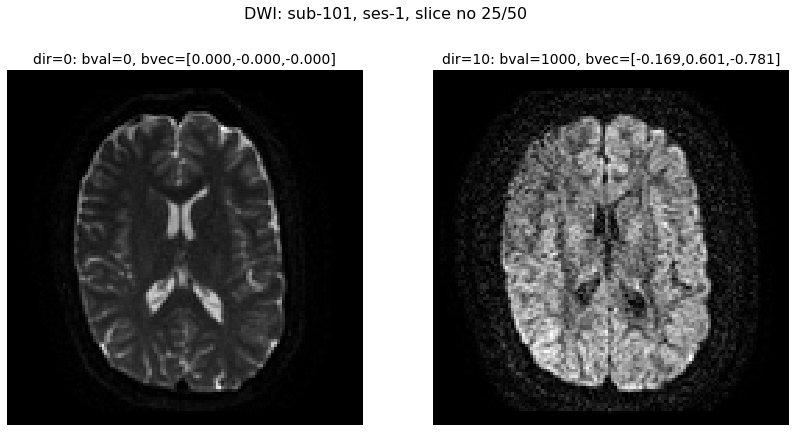

In [6]:
# Inspect data

plt.rcParams["figure.figsize"] = (14,7)

b1 = 0
b2 = 10
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, b1].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b1, bvals[b1], bvecs[b1][0],bvecs[b1][1], bvecs[b1][2]), size=14)
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, b2].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b2, bvals[b2], bvecs[b2][0],bvecs[b2][1], bvecs[b2][2]), size=14)
plt.suptitle('DWI: sub-%d, ses-%d, slice no %d/%d' % (sub, ses, axial_middle, data.shape[2]), size=16)
plt.savefig('./assets/dipy_data.png', bbox_inches='tight')
plt.show()

## Reconstruction of the diffusion signal with the Tensor model

See https://dipy.org/documentation/1.1.1./examples_built/reconst_dti/#example-reconst-dti

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994], it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

The diffusion tensor models the diffusion signal as:

$$\frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^T \mathbf{D} \mathbf{g}}$$
    
Where $\mathbf{g}$ is a unit vector in 3 space indicating the direction of
measurement and $b$ are the parameters of measurement, such as the strength and
duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the
diffusion-weighted signal measured and $S_0$ is the signal conducted in a
measurement with no diffusion weighting. $\mathbf{D}$ is a positive-definite
quadratic form, which contains six free parameters to be fit. These six
parameters are:

$$\begin{split}\mathbf{D} = \begin{pmatrix} D_{xx} &  D_{xy} & D_{xz} \\
                    D_{yx} & D_{yy} & D_{yz} \\
                    D_{zx} & D_{zy} &  D_{zz} \\ \end{pmatrix}\end{split}$$
                    
This matrix is a variance/covariance matrix of the diffusivity along the three
spatial dimensions. Note that we can assume that diffusivity has antipodal
symmetry, so elements across the diagonal are equal. For example:
$D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate
here. In the following example we show how to reconstruct your diffusion datasets
using a single tensor model.

Now that we have prepared the datasets we can go forward with the voxel reconstruction.

`dipy.reconst` is for the reconstruction algorithms which we use to create voxel models from the raw data.

### First, we instantiate the Tensor model in the following way.

In [7]:
tenmodel = dti.TensorModel(gtab)

Fitting the data is very simple. We just need to call the fit method of the TensorModel in the following way:

In [8]:
%%time
tenfit = tenmodel.fit(dwi_4d_masked)

CPU times: user 5min 33s, sys: 4.07 s, total: 5min 37s
Wall time: 30.2 s


The fit method creates a TensorFit object which contains the fitting parameters and other attributes of the model. For example we can generate fractional anisotropy (FA) from the eigen-values of the tensor. FA is used to characterize the degree to which the distribution of diffusion in a voxel is directional. That is, whether there is relatively unrestricted diffusion in one particular direction.

Mathematically, FA is defined as the normalized variance of the eigen-values of the tensor:

$$FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
            \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
            \lambda_2^2+\lambda_3^2}}$$
            
Note that FA should be interpreted carefully. It may be an indication of the
density of packing of fibers in a voxel, and the amount of myelin wrapping
these axons, but it is not always a measure of “tissue integrity”. For example,
FA may decrease in locations in which there is fanning of white matter fibers,
or where more than one population of white matter fibers crosses.

Other tensor statistics can be calculated from the tenfit object. For example, a commonly calculated statistic is the mean diffusivity (MD). This is simply the mean of the eigenvalues of the tensor. Since FA is a normalized measure of variance and MD is the mean, they are often used as complimentary measures. In DIPY, there are two equivalent ways to calculate the mean diffusivity. One is by calling the mean_diffusivity module function on the eigen-values of the TensorFit class instance.

In [9]:
print('Computing anisotropy measures (FA, MD, AD, RD, RGB)')

Computing anisotropy measures (FA, MD, AD, RD, RGB)


### Classes and functions for fitting tensors

See `dti??`  for more details

- def fractional_anisotropy(evals, axis=-1):

$$
       FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}
$$

- geodesic_anisotropy(evals, axis=-1):<br>
[1] P. G. Batchelor, M. Moakher, D. Atkinson, F. Calamante, A. Connelly, "A rigorous framework for diffusion tensor calculus", Magnetic Resonance in Medicine, vol. 53, pp. 221-225, 2005.
$$
        GA = \sqrt{\sum_{i=1}^3
        \log^2{\left ( \lambda_i/<\mathbf{D}> \right )}},
        \quad \textrm{where} \quad <\mathbf{D}> =
        (\lambda_1\lambda_2\lambda_3)^{1/3}
$$

- def mean_diffusivity(evals, axis=-1):<br>
$$
MD = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}
$$

- def axial_diffusivity(evals, axis=-1):<br>

$$
AD = \lambda_1
$$

- def radial_diffusivity(evals, axis=-1):<br>

$$
 RD = \frac{\lambda_2 + \lambda_3}{2}
$$

- def trace(evals, axis=-1):<br>

$$
 Trace = \lambda_1 + \lambda_2 + \lambda_3
$$

- def color_fa(fa, evecs):<br>
    rgb : Array with 3 channels for each color as the last dimension. Colormap of the FA with red for the x value, y for the green value and z for the blue value.

$$
     rgb = abs(max(\vec{e})) \times fa
$$

Note that while the tensor model is an accurate and reliable model of the
diffusion signal in the white matter, it has the drawback that it only has one
principal diffusion direction. Therefore, in locations in the brain that
contain multiple fiber populations crossing each other, the tensor model may
indicate that the principal diffusion direction is intermediate to these
directions. Therefore, using the principal diffusion direction for tracking in
these locations may be misleading and may lead to errors in defining the
tracks. Fortunately, other reconstruction methods can be used to represent the
diffusion and fiber orientations in those locations. These are presented in
other examples.

## Define function `tensor_features`

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser, join
import dipy
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, mean_diffusivity, axial_diffusivity, radial_diffusivity, color_fa

In [11]:
def tensor_features(inpdir, sub, ses, brain_mask, outdir):
    r"""
    Fitting a tensor and calculating dti-derived features (FA, etc.) of a DWI recording (assuming BIDS).

    Parameters
    ----------
    inpdir     : input directory where the BIDS lives, e.g. bids_toro
    sub        : subject id, e.g. 101 for sub-101
    ses        : session number, e.g. 1 for ses-1
    brain_mask : full path name of .nii.gz brain mask file obtained from e.g. fsl_anat brain extraction and affine registration to DWI native space
                 cf. '07-dipy-find-affine-brainmaks2dwi.ipynb' 
    outdir     : output directory where resulting feature .nii.gz files are stored, e.g. dipy_analysis

    Returns
    -------
    FA, MD, AD, RD, RGB : arrays
    FA range is 0 <= FA <= 1
    RGB : Array with 3 channels for each color as the last dimension. 
          Colormap of the FA with red for the x value, y for the green value and z for the blue value.

    Notes
    -----
    FA, MD, AD, RD, RGB are calculated using the following equations:

    .. math::

        FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}
                    
        MD = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}
        
        
        AD = \lambda_1
        
        RD = \frac{\lambda_2 + \lambda_3}{2}
        
        rgb = abs(max(\vec{e})) \times FA

    """
    
    fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
    fdwi = join(inpdir, '%s.nii.gz' % fn)
    fbval = join(inpdir, '%s.bval' % fn)
    fbvec = join(inpdir, '%s.bvec' % fn)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    
    # Brain mask (binary)
    # Typically: fn_dwi_bin_msk = join(outdir, 'sub_%d_tp%d_T1_biascorr_brain_mask_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    fn_dwi_bin_msk =  brain_mask
    
    dwi_bin_msk_data, dwi_bin_msk_affine, dwi_bin_msk_img = load_nifti(fn_dwi_bin_msk, return_img=True)             
    
    # using broadcasting in numpy to obtain brain-mask in 4D (according to dwi shape)            
    dwi_4d_mask = dwi_bin_msk_data[:,:,:,np.newaxis]*data            
    
    # Tensor model and model fitting
    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(dwi_4d_mask)
    
    FA = fractional_anisotropy(tenfit.evals)
    
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    
    MD = mean_diffusivity(tenfit.evals)
    AD = axial_diffusivity(tenfit.evals)
    RD = radial_diffusivity(tenfit.evals)
    
    RGB = color_fa(FA, tenfit.evecs)
    
    fname = join(outdir, 'sub_%d_tp%d_dwi_brainmask' % (sub, ses))
    save_nifti(fname + '_tensor_fa.nii.gz', FA.astype(np.float32), affine)
    save_nifti(fname + '_tensor_md.nii.gz', MD.astype(np.float32), affine)
    save_nifti(fname + '_tensor_ad.nii.gz', AD.astype(np.float32), affine)
    save_nifti(fname + '_tensor_rd.nii.gz', RD.astype(np.float32), affine)
    
    save_nifti(fname + '_tensor_evals.nii.gz', tenfit.evals.astype(np.float32), affine)
    save_nifti(fname + '_tensor_evecs.nii.gz', tenfit.evecs.astype(np.float32), affine)
    
    save_nifti(fname + '_tensor_rgb.nii.gz', np.array(255 * RGB, 'uint8'), affine)

    return FA, MD, AD, RD, RGB


### Test the function

In [12]:
%%time
inpdir = join(os.getcwd(), 'data', 'bids_toro')
outdir = join(os.getcwd(), 'data', 'dipy_analysis')

sub = 101
ses = 1
brain_mask = join(outdir,'sub_%d_tp%d_T1_biascorr_brain_mask_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))

FA, MD, AD, RD, RGB = tensor_features(inpdir, sub, ses, brain_mask, outdir)

CPU times: user 5min 41s, sys: 4.09 s, total: 5min 45s
Wall time: 31.5 s


In [13]:
# Requires installation of FSL:
# !fsleyes ./data/dipy_analysis/sub_101_tp1_dwi_brainmask_tensor_rgb.nii.gz

In [14]:
FA.shape

(128, 128, 50)

In [15]:
FA.mean().round(4)

0.0798

In [16]:
help(tensor_features)

Help on function tensor_features in module __main__:

tensor_features(inpdir, sub, ses, brain_mask, outdir)
    Fitting a tensor and calculating dti-derived features (FA, etc.) of a DWI recording (assuming BIDS).
    
    Parameters
    ----------
    inpdir     : input directory where the BIDS lives, e.g. bids_toro
    sub        : subject id, e.g. 101 for sub-101
    ses        : session number, e.g. 1 for ses-1
    brain_mask : full path name of .nii.gz brain mask file obtained from e.g. fsl_anat brain extraction and affine registration to DWI native space
                 cf. '07-dipy-find-affine-brainmaks2dwi.ipynb' 
    outdir     : output directory where resulting feature .nii.gz files are stored, e.g. dipy_analysis
    
    Returns
    -------
    FA, MD, AD, RD, RGB : arrays
    FA range is 0 <= FA <= 1
    RGB : Array with 3 channels for each color as the last dimension. 
          Colormap of the FA with red for the x value, y for the green value and z for the blue value.
  

## Run for all subjects

In [17]:
from os.path import expanduser, join
import sys
sys.path.append('.')   # path to utils.py
import utils
import time

working_dir = join(os.getcwd(), 'data')
inpdir = '%s/bids_toro' % (working_dir)
outdir = '%s/dipy_analysis' % (working_dir)

In [18]:
%%time
nsubj = 1 # 30
ses=1

for i in utils.progressbar(range(nsubj), "Computing: ", 40):
    time.sleep(0.1)
    sub = i+101
    
    brain_mask = join(outdir, 'sub_%d_tp%d_T1_biascorr_brain_mask_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    
    FA, MD, AD, RD, RGB = tensor_features(inpdir, sub, ses, brain_mask, outdir)

Computing: [########################################] 1/1
CPU times: user 5min 40s, sys: 4.03 s, total: 5min 44s
Wall time: 31 s


### Display FA-map and color(RGB)-coded diffusion map for given image slice

In [19]:
RGB.shape

(128, 128, 50, 3)

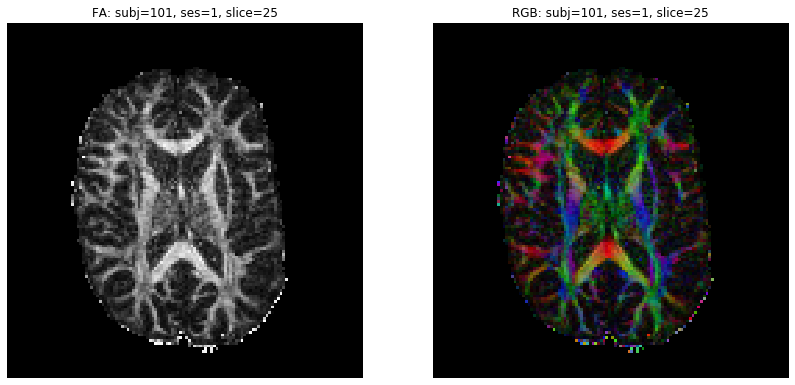

In [20]:
from matplotlib.pyplot import imshow

sub = 101
ses = 1
sl =  25   # FA.shape[2] // 2 # axial_middle slice

plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(FA[:, :, sl].T, cmap='gray', origin='lower')
plt.title('FA: subj=%d, ses=%d, slice=%d' % (sub, ses, sl))

plt.subplot(1, 2, 2).set_axis_off()
img1 = np.squeeze((RGB[:, :, sl, :]))
img = np.transpose(img1, (1, 0, 2))
plt.imshow(img, origin='lower')
plt.title('RGB: subj=%d, ses=%d, slice=%d' % (sub, ses, sl))
plt.show()